In [2]:
import pandas as pd
import numpy as np
from pycaret.time_series import *
import matplotlib.pyplot as plt
import ephem


In [3]:
# W_LEV_AVG	= ค่าระดับน้ำทะเล หน่วยเมตร
# Load your dataset
df = pd.read_csv("data_preprocess/raw_data/dmr_tidal-level-phuket-tidegauge-2013_2023.csv")
# ลบช่องว่างเกินออก (กันกรณีมี space แปลก ๆ)
df["DATE"] = df["DATE"].str.strip()

# เติมเลข 0 ให้ชั่วโมงหลักเดียว และเติม ":00" ถ้าขาดวินาที
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{1}):(\d{2})$", r"\1 0\2:\3:00", regex=True)
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{2}:\d{2})$", r"\1 \2:00", regex=True)

# แปลงเป็น datetime โดยกำหนด dayfirst=True
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df.set_index('DATE', inplace=True)
df = df.drop(columns=["TW_ID", "TW_NAME", "UTM_E", 'UTM_N'], axis=1)
df.dropna(inplace=True)
df = df.resample("H").mean()

In [4]:
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year

In [5]:
# ลบค่าที่ซ้ำกันใน index
df = df[~df.index.duplicated(keep="last")]

In [6]:
# กำหนดความถี่ของข้อมูลเป็นชั่วโมง
df = df.asfreq("H")

In [7]:
# เติมค่าหายไปโดยใช้ Interpolation แบบ Time-based
df.interpolate(method='time', inplace=True)

In [9]:
# สร้างคอลัมน์ moon_phase (ค่าจาก 0-1)
def get_moon_phase(date):
    moon = ephem.Moon(date)
    phase = moon.phase / 100  # ปรับค่าให้อยู่ในช่วง 0-1
    return phase

df["moon_phase"] = df.index.to_series().apply(get_moon_phase)

# เพิ่มคอลัมน์ full_moon_days & dark_moon_days
df["full_moon_days"] = df["moon_phase"].apply(lambda x: 1 if x >= 0.98 else 0)  # พระจันทร์เต็มดวง
df["dark_moon_days"] = df["moon_phase"].apply(lambda x: 1 if x <= 0.02 else 0)  # คืนเดือนมืด
df

,W_LEV_AVG,day,month,year,moon_phase,full_moon_days,dark_moon_days
DATE,,,,,,,
2013-10-01 07:00:00,0.495833,1,10,2013,0.144905,0,0
2013-10-01 08:00:00,0.577550,1,10,2013,0.142009,0,0
2013-10-01 09:00:00,0.477117,1,10,2013,0.139136,0,0
2013-10-01 10:00:00,0.199967,1,10,2013,0.136284,0,0
2013-10-01 11:00:00,-0.198067,1,10,2013,0.133454,0,0
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-1.144383,31,12,2023,0.796284,0,0
2023-12-31 20:00:00,-0.888383,31,12,2023,0.793123,0,0
2023-12-31 21:00:00,-0.470750,31,12,2023,0.789944,0,0


In [10]:
# ฟังก์ชันระบุฤดูกาลของไทย
def get_thai_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9, 10]:
        return 'rainy'
    else:
        return 'winter'

# เพิ่มคอลัมน์ฤดูกาล
df['season'] = df['month'].apply(get_thai_season)

# One-hot encoding ฤดูกาล
df = pd.get_dummies(df, columns=['season'], prefix='season')

# แปลงค่า True/False เป็น 1/0
df[['season_rainy', 'season_summer', 'season_winter']] = df[['season_rainy', 'season_summer', 'season_winter']].astype(int)
df

,W_LEV_AVG,day,month,year,moon_phase,full_moon_days,dark_moon_days,season_rainy,season_summer,season_winter
DATE,,,,,,,,,,
2013-10-01 07:00:00,0.495833,1,10,2013,0.144905,0,0,1,0,0
2013-10-01 08:00:00,0.577550,1,10,2013,0.142009,0,0,1,0,0
2013-10-01 09:00:00,0.477117,1,10,2013,0.139136,0,0,1,0,0
2013-10-01 10:00:00,0.199967,1,10,2013,0.136284,0,0,1,0,0
2013-10-01 11:00:00,-0.198067,1,10,2013,0.133454,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-1.144383,31,12,2023,0.796284,0,0,0,0,1
2023-12-31 20:00:00,-0.888383,31,12,2023,0.793123,0,0,0,0,1
2023-12-31 21:00:00,-0.470750,31,12,2023,0.789944,0,0,0,0,1


In [25]:
train_data = df[:-72]
test_data = df[-72:]
test_data

,W_LEV_AVG,day,month,year,moon_phase,full_moon_days,dark_moon_days,season_rainy,season_summer,season_winter
DATE,,,,,,,,,,
2023-12-29 00:00:00,0.742833,29,12,2023,0.959351,0,0,0,0,1
2023-12-29 01:00:00,0.326967,29,12,2023,0.957757,0,0,0,0,1
2023-12-29 02:00:00,-0.272983,29,12,2023,0.956134,0,0,0,0,1
2023-12-29 03:00:00,-0.929783,29,12,2023,0.954482,0,0,0,0,1
2023-12-29 04:00:00,-1.466067,29,12,2023,0.952801,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-1.144383,31,12,2023,0.796284,0,0,0,0,1
2023-12-31 20:00:00,-0.888383,31,12,2023,0.793123,0,0,0,0,1
2023-12-31 21:00:00,-0.470750,31,12,2023,0.789944,0,0,0,0,1


In [12]:
train_data

,W_LEV_AVG,day,month,year,moon_phase,full_moon_days,dark_moon_days,season_rainy,season_summer,season_winter
DATE,,,,,,,,,,
2013-10-01 07:00:00,0.495833,1,10,2013,0.144905,0,0,1,0,0
2013-10-01 08:00:00,0.577550,1,10,2013,0.142009,0,0,1,0,0
2013-10-01 09:00:00,0.477117,1,10,2013,0.139136,0,0,1,0,0
2013-10-01 10:00:00,0.199967,1,10,2013,0.136284,0,0,1,0,0
2013-10-01 11:00:00,-0.198067,1,10,2013,0.133454,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2023-12-28 19:00:00,-0.889317,28,12,2023,0.966873,0,0,0,0,1
2023-12-28 20:00:00,-0.311317,28,12,2023,0.965429,0,0,0,0,1
2023-12-28 21:00:00,0.263433,28,12,2023,0.963954,0,0,0,0,1


In [32]:
exp = TSForecastingExperiment()
exp.setup(
    data=train_data,
    target='W_LEV_AVG',
    session_id=123,
    fh=72,
    use_gpu=True,
    seasonal_period=[12, 24, 336],  # ตั้ง seasonality ตามน้ำขึ้นน้ำลง
    numeric_imputation_target='mean',  # เติมค่าที่หายไปด้วยค่าเฉลี่ย
    numeric_imputation_exogenous='mean',  # เติมค่าที่หายไปด้วยค่าเฉลี่ย
)

,Description,Value
0,session_id,123
1,Target,W_LEV_AVG
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(89777, 10)"
5,Transformed data shape,"(89777, 10)"
6,Transformed train set shape,"(89705, 10)"
7,Transformed test set shape,"(72, 10)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [ ]:
best_model = exp.create_model('arima')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-12-16 23:00,2.4762,2.5003,0.5602,0.6923,2.0625,0.9978,0.0868
1,2023-12-19 23:00,1.9992,2.0545,0.4526,0.5692,3.3911,1.0730,-0.1784
2,2023-12-22 23:00,2.8393,2.8454,0.6429,0.7883,5.7406,1.1982,-0.4172
Mean,NaT,2.4382,2.4667,0.5519,0.6832,3.7314,1.0897,-0.1696
SD,NaT,0.3440,0.3237,0.0779,0.0897,1.5208,0.0826,0.2058


In [39]:
best_model = exp.tune_model(best_model)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-12-16 23:00,5.5082,5.4846,1.2462,1.5185,3.8522,1.4419,-3.3942
1,2023-12-19 23:00,2.5020,2.7901,0.5664,0.7729,3.0491,1.1108,-1.1733
2,2023-12-22 23:00,4.5627,4.5138,1.0330,1.2506,5.3698,1.4689,-2.5664
Mean,NaT,4.1910,4.2629,0.9485,1.1807,4.0903,1.3406,-2.3780
SD,NaT,1.2551,1.1143,0.2839,0.3084,0.9623,0.1628,0.9164


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 104.0min finished


In [40]:
best_model = exp.finalize_model(best_model)

In [41]:
exp.save_model(best_model, 'models/Second_models')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('transformer_exogenous',
                             TransformerPipeline(steps=[('numerical_imputer',
                                                         Imputer(method='mean',
                                                                 random_state=123))])),
                            ('forecaster',
                             TransformedTargetForecaster(steps=[('transformer_target',
                                                                 TransformerPipeline(steps=[('numerical_imputer',
                                                                                             Imputer(method='mean',
                                                                                                     random_state=123))])),
                                                                ('model',
                                                                 ForecastingPipeline(steps=[('transformer_exogenous',
                        

In [31]:
best_model = load_model('models\Second_models')

Transformation Pipeline and Model Successfully Loaded


In [26]:
test_data.index = test_data.index.to_period("H")  # หรือ "D" ถ้าเป็น daily

In [32]:
# ทำนายค่า pm_2_5
forecast = predict_model(best_model, fh=72, X=test_data.drop(columns="W_LEV_AVG"))

# แสดงผลลัพธ์
print("Forecast:")
print(forecast)
print(test_data['W_LEV_AVG'])

Forecast:
                  y_pred
2023-12-29 00:00  0.6817
2023-12-29 01:00  0.2938
2023-12-29 02:00 -0.2153
2023-12-29 03:00 -0.7248
2023-12-29 04:00 -1.0684
...                  ...
2023-12-31 19:00 -0.3718
2023-12-31 20:00  0.1689
2023-12-31 21:00  0.7090
2023-12-31 22:00  1.1377
2023-12-31 23:00  1.2811

[72 rows x 1 columns]
DATE
2023-12-29 00:00    0.742833
2023-12-29 01:00    0.326967
2023-12-29 02:00   -0.272983
2023-12-29 03:00   -0.929783
2023-12-29 04:00   -1.466067
                      ...   
2023-12-31 19:00   -1.144383
2023-12-31 20:00   -0.888383
2023-12-31 21:00   -0.470750
2023-12-31 22:00    0.013400
2023-12-31 23:00    0.446050
Freq: H, Name: W_LEV_AVG, Length: 72, dtype: float64


In [34]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ดึงค่าจริงจาก test_data
actual = test_data['W_LEV_AVG']

# ดึงค่าทำนายจาก forecast
predicted = forecast['y_pred']

# คำนวณ MAE
mae = mean_absolute_error(actual, predicted)

# คำนวณ MSE
mse = mean_squared_error(actual, predicted)

# คำนวณ RMSE
rmse = np.sqrt(mse)

# คำนวณ MAPE
def calculate_mape(actual, predicted):
    mask = actual != 0  # ป้องกันการหารด้วยศูนย์
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

mape = calculate_mape(actual, predicted)

# คำนวณ R²
r2 = r2_score(actual, predicted)

# คำนวณความแม่นยำ (Accuracy) โดยใช้ RMSE
mean_actual = np.mean(actual)
if mean_actual != 0:
    accuracy = max(0, (1 - (rmse / mean_actual)) * 100)  # ป้องกันค่าติดลบ
else:
    accuracy = 0  # ถ้า Mean Actual เป็นศูนย์ กำหนดความแม่นยำเป็น 0%

# แสดงผลลัพธ์
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² (Coefficient of Determination): {r2:.4f}")
print(f"R² (ความแม่นยำ): {r2 * 100:.2f}%")
print(f"ความแม่นยำ (Accuracy): {accuracy:.2f}%")

MAE: 0.5553
MSE: 0.4583
RMSE: 0.6770
MAPE: 415.26%
R² (Coefficient of Determination): 0.1969
R² (ความแม่นยำ): 19.69%
ความแม่นยำ (Accuracy): 254.18%


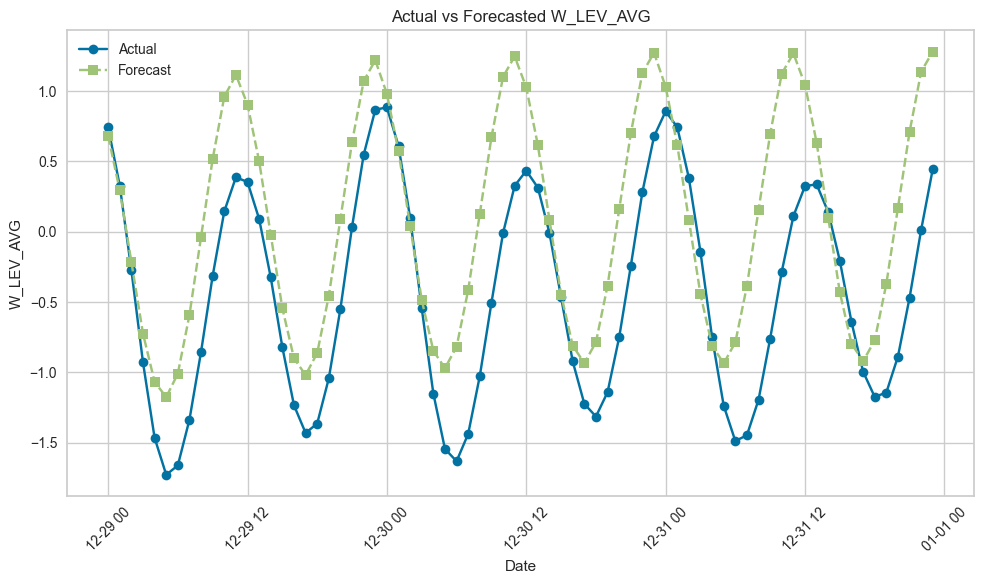

In [37]:
# แก้ไขการพล็อตกราฟเปรียบเทียบค่าจริงกับค่าทำนาย
plt.figure(figsize=(10, 6))
plt.plot(test_data.index.to_timestamp(), test_data['W_LEV_AVG'], label='Actual', marker='o')
plt.plot(predicted.index.to_timestamp(), predicted, label='Forecast', marker='s', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('W_LEV_AVG')
plt.title('Actual vs Forecasted W_LEV_AVG')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
bias = np.mean(actual - predicted)
adjusted_forecast = predicted + bias

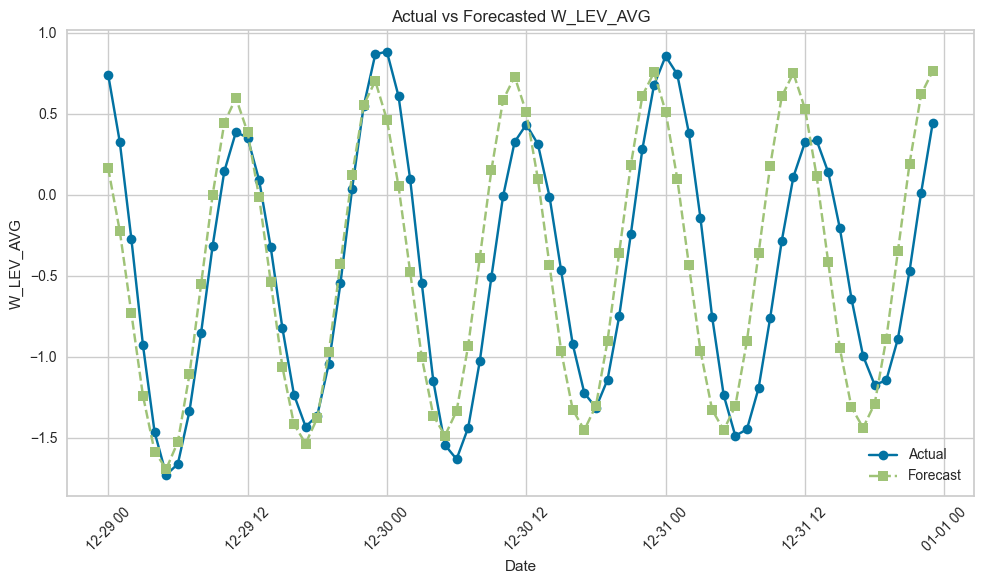

In [58]:
# แก้ไขการพล็อตกราฟเปรียบเทียบค่าจริงกับค่าทำนาย
plt.figure(figsize=(10, 6))
plt.plot(test_data.index.to_timestamp(), test_data['W_LEV_AVG'], label='Actual', marker='o')
plt.plot(adjusted_forecast.index.to_timestamp(), adjusted_forecast, label='Forecast', marker='s', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('W_LEV_AVG')
plt.title('Actual vs Forecasted W_LEV_AVG')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
best_model.get_params()

{'steps': [('transformer_exogenous',
   TransformerPipeline(steps=[('numerical_imputer',
                               Imputer(method='mean', random_state=123))])),
  ('forecaster',
   TransformedTargetForecaster(steps=[('transformer_target',
                                       TransformerPipeline(steps=[('numerical_imputer',
                                                                   Imputer(method='mean',
                                                                           random_state=123))])),
                                      ('model',
                                       ForecastingPipeline(steps=[('transformer_exogenous',
                                                                   TransformerPipeline(steps=[('numerical_imputer',
                                                                                               Imputer(method='mean',
                                                                                                       ran

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ดึงค่าจริงจาก test_data
actual = test_data['W_LEV_AVG']

# ดึงค่าทำนายจาก forecast
predicted = adjusted_forecast

# คำนวณ MAE
mae = mean_absolute_error(actual, predicted)

# คำนวณ MSE
mse = mean_squared_error(actual, predicted)

# คำนวณ RMSE
rmse = np.sqrt(mse)

# คำนวณ MAPE
def calculate_mape(actual, predicted):
    mask = actual != 0  # ป้องกันการหารด้วยศูนย์
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

mape = calculate_mape(actual, predicted)

# คำนวณ R²
r2 = r2_score(actual, predicted)

# คำนวณความแม่นยำ (Accuracy) โดยใช้ RMSE
mean_actual = np.mean(actual)
if mean_actual != 0:
    accuracy = max(0, (1 - (rmse / mean_actual)) * 100)  # ป้องกันค่าติดลบ
else:
    accuracy = 0  # ถ้า Mean Actual เป็นศูนย์ กำหนดความแม่นยำเป็น 0%

# แสดงผลลัพธ์
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² (Coefficient of Determination): {r2:.4f}")
print(f"R² (ความแม่นยำ): {r2 * 100:.2f}%")
print(f"ความแม่นยำ (Accuracy): {accuracy:.2f}%")

MAE: 0.3663
MSE: 0.1913
RMSE: 0.4374
MAPE: 292.64%
R² (Coefficient of Determination): 0.6647
R² (ความแม่นยำ): 66.47%
ความแม่นยำ (Accuracy): 199.62%
